https://teddylee777.github.io/langgraph/langgraph-agentic-rag/

### 예제 구현. 

### 수정 사항 

Chrome -> ES

docs -> 자체 문서

### import envs

In [1]:
from dotenv import load_dotenv
import os
load_dotenv()
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
ES_HOST = os.getenv("ES_HOST")
ES_USER_ID = os.getenv("ES_ID")
ES_PASSWD = os.getenv("ES_PWD")
ES_INDEX_NAME = os.getenv("ES_INDEX_NAME")
EMBEDDING_BASE_URL=os.getenv("EMBEDDING_BASE_URL")
EMBEDDING_MODEL=os.getenv("EMBEDDING_MODEL")
HUGGINGFACEHUB_API_TOKEN = os.getenv("HUGGUNGFACE_TOKEN")

import packages

In [2]:
# from langchain_community.vectorstores.elasticsearch import ElasticsearchStore
# from langchain_community.vectorstores.elastic_vector_search import ElasticKnnSearch
# from langchain_elasticsearch import ElasticsearchStore, DenseVectorStrategy, ElasticsearchEmbeddings
from langchain_elasticsearch import ElasticsearchRetriever
from elasticsearch import Elasticsearch
from langchain_community.embeddings import HuggingFaceHubEmbeddings
from langchain_openai import ChatOpenAI
from pydantic.v1 import BaseModel, Field  # <-- Uses v1 namespace
from langchain.tools import StructuredTool

Embedding 정의

In [3]:
embeddings = HuggingFaceHubEmbeddings(model=EMBEDDING_BASE_URL, huggingfacehub_api_token=HUGGINGFACEHUB_API_TOKEN)

/Users/nuri/dev/jupyter/.venv/lib/python3.9/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceHubEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEndpointEmbeddings`.
  warn_deprecated(


ES Retrieve 정의

### metadata field 정의

In [4]:
from langchain.chains.query_constructor.base import AttributeInfo
metadata_field_info = [
    AttributeInfo(
        name="title",
        description="The title of the article or document",
        type="string",
    ),
    AttributeInfo(
        name="created_date",
        description="The creation date of the article or document. That field format is 'YYYY-MM-DD' ",
        type="date",
    ),
    
    AttributeInfo(
        name="portal",
        description="portal of the article or document. It can be daum, naver, etc",
        type="string",
    ),
    AttributeInfo(
        name="media", description="The newspaper that created the article", type="String"
    ),
    AttributeInfo(
        name="url", description="The URL address where the data was posted", type="String"
    ),
    AttributeInfo(
        name="image_url", description="The URL of the image included in the article", type="String"
    ),
]
type(metadata_field_info[0])

langchain.chains.query_constructor.schema.AttributeInfo

In [5]:
import typing as t 
def hybrid_query(search_query: str) -> t.Dict:
    vector = embeddings.embed_query(search_query)  # same embeddings as for indexing
    return {
        "_source": ["text","metadata"], 
        "query": {
            "match": {
                'text': search_query,
            },
        },
        "knn": {
            "field": 'vector',
            "query_vector": vector,
            "k": 50,
            "num_candidates": 100,
        },
        "rank": {"rrf": {}},
        
    }

In [6]:
from typing import Any, Callable, Dict, List, Mapping, Optional, Sequence, Union, cast

es = Elasticsearch([ES_HOST], basic_auth=(ES_USER_ID, ES_PASSWD), ca_certs="./../certs/ca.crt", verify_certs=False, timeout=120)

es_retriever = ElasticsearchRetriever(
    es_client=es,
    index_name = ES_INDEX_NAME,
    body_func=hybrid_query,
    content_field="text",
)
search_results = es_retriever.invoke("삼성전자")
print(search_results[0])
# If we want, we can create other tools.
# Once we have all the tools we want, we can put them in a list that we will reference later.

/var/folders/jy/5_rl6575533638lskdr9s6s00000gn/T/ipykernel_56670/1068145591.py:3: DeprecationWarning: The 'timeout' parameter is deprecated in favor of 'request_timeout'
  es = Elasticsearch([ES_HOST], basic_auth=(ES_USER_ID, ES_PASSWD), ca_certs="./../certs/ca.crt", verify_certs=False, timeout=120)
/Users/nuri/dev/jupyter/.venv/lib/python3.9/site-packages/elasticsearch/_sync/client/__init__.py:399: SecurityWarning: Connecting to 'https://192.168.0.10:9200' using TLS with verify_certs=False is insecure
  _transport = transport_class(


page_content='삼성 경영진은 전영현 삼성전자 DS부문장 부회장, 노태문 삼성전자 DX부문 MX사업부장 사장, 박학규 삼성전자 경영지원실장, 최윤호 삼성SDI 대표이사 사장, 최주선 삼성디스플레이 대표이사 사장, 양걸 삼성전자 삼성차이나 사장, 김원경 삼성전자 글로벌공공업무실장 사장 등이 참석했습니다.
(사진=삼성전자 제공, 연합뉴스)
유덕기 기자 dkyu@sbs.co.kr
Copyright © Copyright ⓒ SBS. All rights reserved. 무단 전재, 재배포 및 AI학습 이용 금지' metadata={'_index': 'news_article_embedding', '_id': '814776b4-3d3f-40ca-8a45-0475928b54f1', '_score': None, '_rank': 1, '_ignored': ['text.keyword'], '_source': {'metadata': {'id': 611501, 'hash_key': '1226b4a4c70e7bc5fee64513bdc3ef81', 'title': '이재용, 리창 중국 총리 면담…삼성 중국 사업 지원 감사 뜻 전달', 'created_date': '2024-05-26T22:45:00', 'portal': 'daum', 'media': 'SBS', 'url': 'https://v.daum.net/v/20240526224500535', 'image_url': 'https://img1.daumcdn.net/thumb/S1200x630/?fname=https://t1.daumcdn.net/news/202405/26/sbsi/20240526224502831pvnt.jpg'}}}


/Users/nuri/dev/jupyter/.venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1063: InsecureRequestWarning: Unverified HTTPS request is being made to host '192.168.0.10'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [7]:
class SearchToolInput(BaseModel):
    """Input for the index show data tool."""

    index_name: str = Field(
        ..., description="The name of the index for which the data is to be retrieved. in this case indexname will be " + ES_INDEX_NAME
    )
    query: str = Field(..., description="The ElasticSearch JSON query used to filter all hits. Should use the _source field if possible to specify required fields.")
    from_: int = Field(
        ..., description="The record index from which the query will start"
    )
    size: int = Field(
        ...,
        description="How many records will be retrieved from the ElasticSearch query",
    )

tool 정의

In [8]:
def create_es_search_tool():
      return StructuredTool(name="elastic_index_search_tool",
                            func=es_retriever.get_relevant_documents, 
                            args_schema=SearchToolInput)
tools = [create_es_search_tool()]
# tools = [retriever.as_tool()]

tool executor 정의

In [9]:
from langgraph.prebuilt import ToolExecutor
tool_executor = ToolExecutor(tools)

# Graph 정의
## Agent State 정의

In [10]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    # AgentState 클래스는 메시지 시퀀스를 포함하는 타입 딕셔너리입니다.
    messages: Annotated[Sequence[BaseMessage], operator.add]

## 노드와 엣지

agenticRag 그래프를 구성.

 상태는 메세지 집합<br>
 각 노드는 상태를 업데이터(추가)<br>
 조건부 엣지는 다음에 방문한 노드를 결정<br>

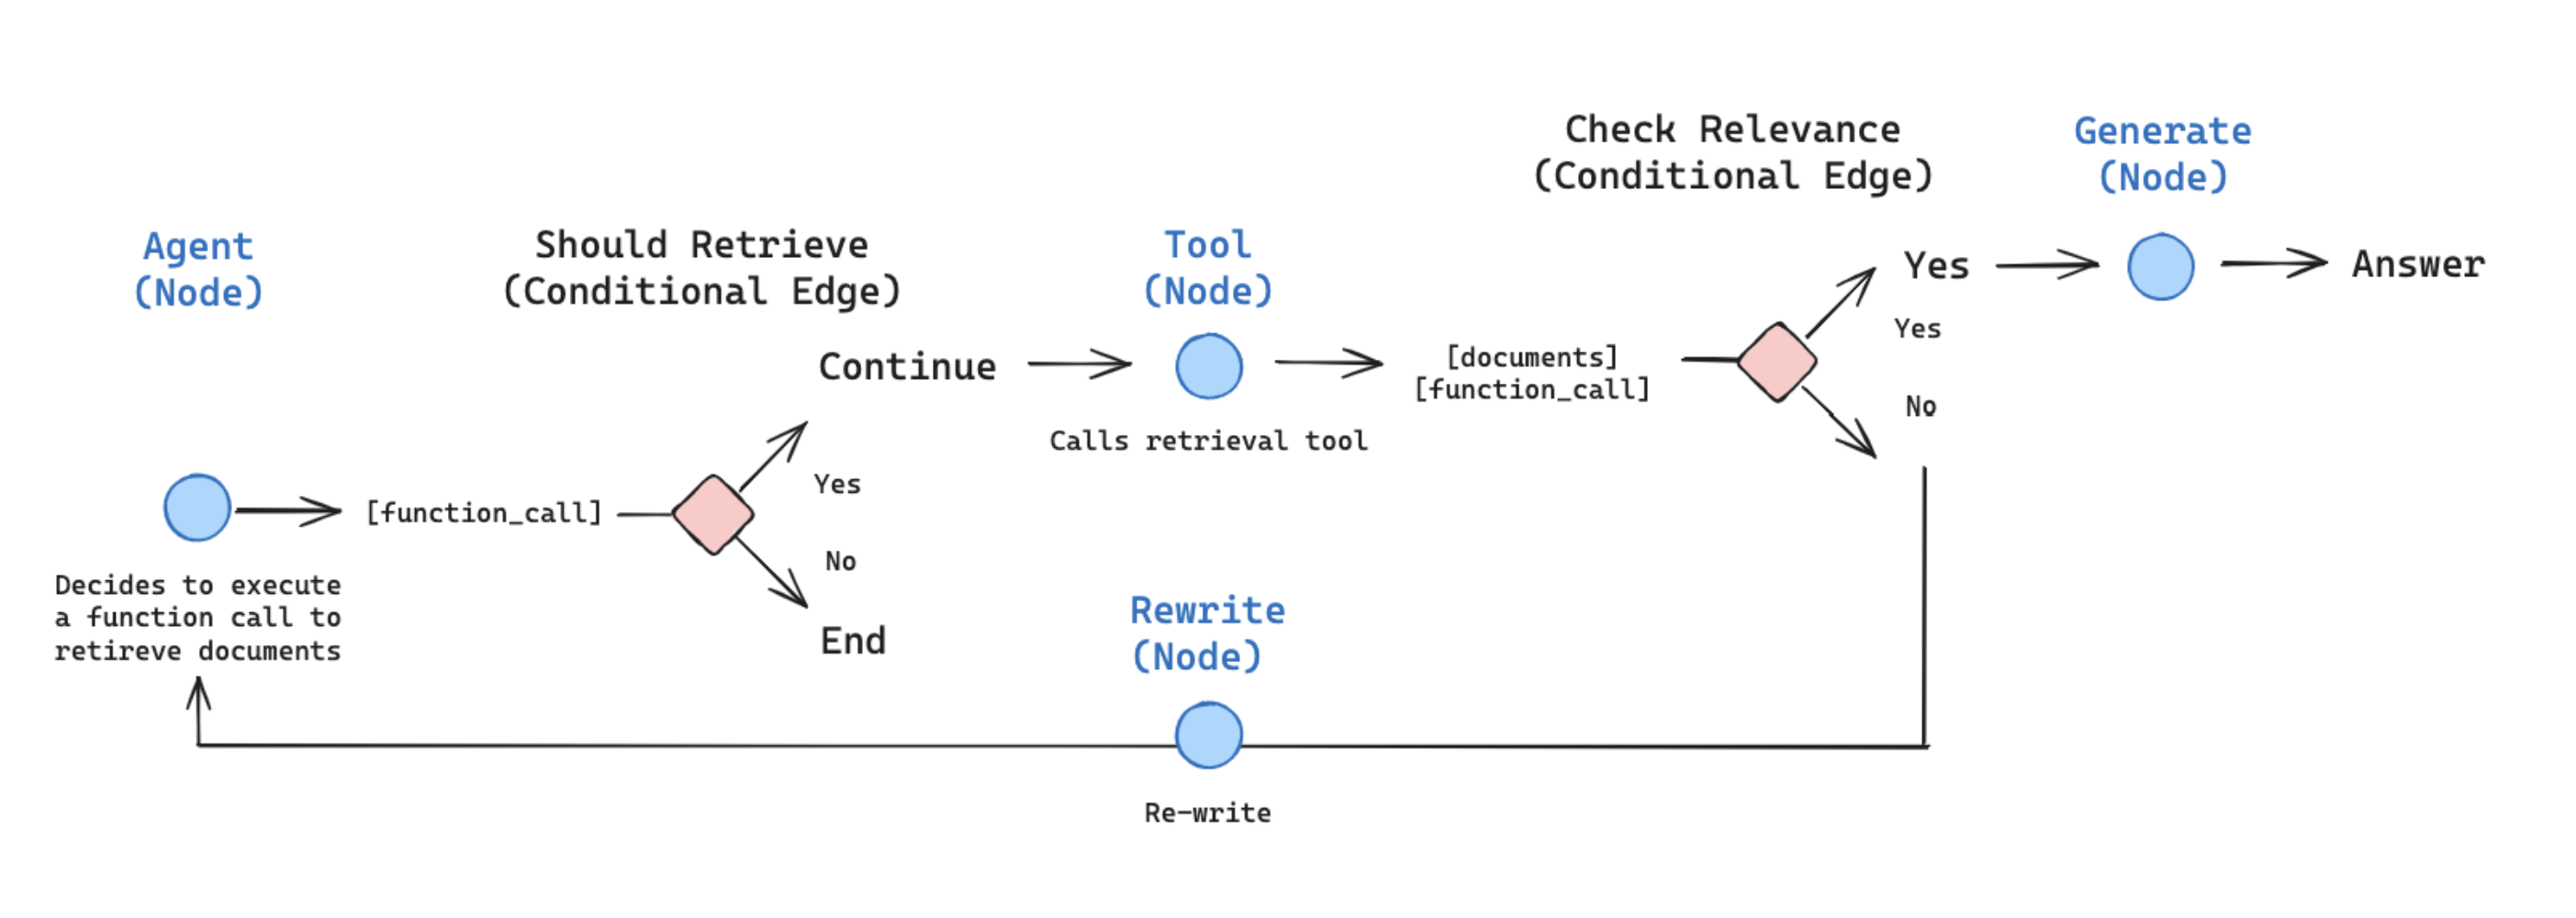

문서 검색, 관련성 평가, 질문 재구성, 답변 생성을 포함하는 정보 검색 및 처리 프로세스를 구현 <br>
1. 첫 단계에서는 에이전트가 추가 정보를 검색 해야 하는지 결정(should_retrieve)
2. 다음으로, 검색된 문서가 주어진 질문과 관련이 있는지 평가(grade_documents)
3. 질문을 재구성하여 더 나은 질문을 생성(rewrite)
4. 최종적으로 검색된 문서를 바탕으로 답변을 생성(generate)


In [11]:
import json
import operator
from typing import Annotated, Sequence, TypedDict

from langchain import hub
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_core.messages import BaseMessage, FunctionMessage
from langchain.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolInvocation
from langchain_core.output_parsers import StrOutputParser


### Edges

In [12]:

def should_retrieve(state):
    """
    에이전트가 더 많은 정보를 검색해야 하는지 또는 프로세스를 종료해야 하는지 결정합니다.

    이 함수는 상태의 마지막 메시지에서 함수 호출을 확인합니다. 함수 호출이 있으면 정보 검색 프로세스를 계속합니다. 그렇지 않으면 프로세스를 종료합니다.

    Args:
        state (messages): 현재 상태

    Returns:
        str: 검색 프로세스를 "계속"하거나 "종료"하는 결정
    """

    print("---DECIDE TO RETRIEVE---")
    messages = state["messages"]
    last_message = messages[-1]

    # 함수 호출이 없으면 종료합니다.
    if "function_call" not in last_message.additional_kwargs:
        print("---DECISION: DO NOT RETRIEVE / DONE---")
        return "end"
    # 그렇지 않으면 함수 호출이 있으므로 계속합니다.
    else:
        print("---DECISION: RETRIEVE---")
        return "continue"


def grade_documents(state):
    """
    검색된 문서가 질문과 관련이 있는지 여부를 결정합니다.

    Args:
        state (messages): 현재 상태

    Returns:
        str: 문서가 관련이 있는지 여부에 대한 결정
    """

    print("---CHECK RELEVANCE---")

    # 데이터 모델
    class grade(BaseModel):
        """관련성 검사를 위한 이진 점수."""

        binary_score: str = Field(description="'yes' 또는 'no'의 관련성 점수")

    # LLM
    model = ChatOpenAI(
        temperature=0, model="gpt-4o", streaming=True)

    # 도구
    grade_tool_oai = convert_to_openai_tool(grade)

    # 도구와 강제 호출을 사용한 LLM
    llm_with_tool = model.bind(
        tools=[convert_to_openai_tool(grade_tool_oai)],
        tool_choice={"type": "function", "function": {"name": "grade"}},
    )

    # 파서
    parser_tool = PydanticToolsParser(tools=[grade])

    # 프롬프트
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # 체인
    chain = prompt | llm_with_tool | parser_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    score = chain.invoke({"question": question, "context": docs})

    grade = score[0].binary_score

    if grade == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "yes"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(grade)
        return "no"

# Nodes

In [13]:
def agent(state):
    """
    현재 상태를 기반으로 에이전트 모델을 호출하여 응답을 생성합니다. 질문에 따라 검색 도구를 사용하여 검색을 결정하거나 단순히 종료합니다.

    Args:
        state (messages): 현재 상태

    Returns:
        dict: 메시지에 에이전트 응답이 추가된 업데이트된 상태
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOpenAI(temperature=0, streaming=True,
                       model="gpt-4o")
    functions = [format_tool_to_openai_function(t) for t in tools]
    model = model.bind_functions(functions)
    response = model.invoke(messages)
    # 이것은 기존 목록에 추가될 것이므로 리스트를 반환합니다.
    return {"messages": [response]}


def retrieve(state):
    """
    도구를 사용하여 검색을 실행합니다.

    Args:
        state (messages): 현재 상태

    Returns:
        dict: 검색된 문서가 추가된 업데이트된 상태
    """
    print("---EXECUTE RETRIEVAL---")
    messages = state["messages"]
    # 계속 조건을 기반으로 마지막 메시지가 함수 호출을 포함하고 있음을 알 수 있습니다.
    last_message = messages[-1]
    # 함수 호출에서 ToolInvocation을 구성합니다.
    action = ToolInvocation(
        tool=last_message.additional_kwargs["function_call"]["name"],
        tool_input=json.loads(
            last_message.additional_kwargs["function_call"]["arguments"]
        ),
    )
    # 도구 실행자를 호출하고 응답을 받습니다.
    response = tool_executor.invoke(action)
    function_message = FunctionMessage(content=str(response), name=action.tool)

    # 이것은 기존 목록에 추가될 것이므로 리스트를 반환합니다.
    return {"messages": [function_message]}


def rewrite(state):
    """
    질문을 변형하여 더 나은 질문을 생성합니다.

    Args:
        state (messages): 현재 상태

    Returns:
        dict: 재구성된 질문이 추가된 업데이트된 상태
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # 평가자
    model = ChatOpenAI(
        temperature=0, model="gpt-4o", streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}


def generate(state):
    """
    답변 생성

    Args:
        state (messages): 현재 상태

    Returns:
         dict: 재구성된 질문이 추가된 업데이트된 상태
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    # 프롬프트
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOpenAI(model_name="gpt-4o",
                     temperature=0, streaming=True)

    # 후처리
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # 체인
    rag_chain = prompt | llm | StrOutputParser()

    # 실행
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

# Graph 정의

에이전트로 시작, call_model <br>
에이전트는 함수를 호출할지 결정 <br>
만약 호출한다면, 도구(검색기)를 호출하는 action을 수행
그 다음 메세지(state)에 도구의 출력을 추가하여 에이전트를 호출

StateGraph 클래스를 상태 기반 그래프를 정의, 관리

In [14]:
from langgraph.graph import END, StateGraph

# langgraph.graph에서 StateGraph와 END를 가져옵니다.
workflow = StateGraph(AgentState)

# 순환할 노드들을 정의합니다.
workflow.add_node("agent", agent)  # 에이전트 노드를 추가합니다.
workflow.add_node("retrieve", retrieve)  # 정보 검색 노드를 추가합니다.
workflow.add_node("rewrite", rewrite)  # 정보 재작성 노드를 추가합니다.
workflow.add_node("generate", generate)  # 정보 생성 노드를 추가합니다.

In [15]:
workflow.set_entry_point("agent")

# 검색 여부 결정
workflow.add_conditional_edges(
    "agent",
    # 에이전트 결정 평가
    should_retrieve,
    {
        # 도구 노드 호출
        "continue": "retrieve",
        "end": END,
    },
)

# `action` 노드 호출 후 진행될 경로
workflow.add_conditional_edges(
    "retrieve",
    # 에이전트 결정 평가
    grade_documents,
    {
        "yes": "generate",
        "no": "rewrite",
    },
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# 컴파일
app = workflow.compile()

In [16]:
import pprint
from langchain_core.messages import HumanMessage

# HumanMessage 객체를 사용하여 질문 메시지를 정의합니다.
inputs = {
    "messages": [
        HumanMessage(
            content="""
            HBM이 언급된 기사를 찾아서 관련 회사를 표시해줘
            같은 내용의 기사는 중복을 제거해줘
            그리고 기사가 영문일 경우 한글로 표시해줘"""
        )
    ]
}
# app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
for output in app.stream(inputs):
    # 출력된 결과에서 키와 값을 순회합니다.
    for key, value in output.items():
        # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        # 출력 값을 예쁘게 출력합니다.
        pprint.pprint(value, indent=2, width=80, depth=None)
    # 각 출력 사이에 구분선을 추가합니다.
    pprint.pprint("\n---\n")

/Users/nuri/dev/jupyter/.venv/lib/python3.9/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The function `format_tool_to_openai_function` was deprecated in LangChain 0.1.16 and will be removed in 0.3.0. Use langchain_core.utils.function_calling.convert_to_openai_function() instead.
  warn_deprecated(


---CALL AGENT---
---DECIDE TO RETRIEVE---
---DECISION: RETRIEVE---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"index_name":"news_article_embedding","query":"{\\"query\\":{\\"match\\":{\\"content\\":\\"HBM\\"}},\\"_source\\":[\\"content\\",\\"company\\"]}","from_":0,"size":10}', 'name': 'elastic_index_search_tool'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_3aa7262c27'}, id='run-a066d333-841c-4a35-8e89-23e085664695-0')]}
'\n---\n'
---EXECUTE RETRIEVAL---


/Users/nuri/dev/jupyter/.venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1063: InsecureRequestWarning: Unverified HTTPS request is being made to host '192.168.0.10'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
"Output from node 'retrieve':"
'---'
{ 'messages': [ FunctionMessage(content='[Document(metadata={\'_index\': \'news_article_embedding\', \'_id\': \'a658fa17-d9f7-4f6e-94d3-0ac72d639c9b\', \'_score\': None, \'_rank\': 1, \'_ignored\': [\'text.keyword\'], \'_source\': {\'metadata\': {\'id\': 39732, \'hash_key\': \'5cf499c5f91d0f83f415ed796afbc632\', \'title\': \'Toho acquires 25 percent stake in Fifth Season for $225 million\', \'created_date\': \'2023-12-11T18:58:30\', \'portal\': \'daum\', \'media\': \'코리아중앙데일리\', \'url\': \'https://v.daum.net/v/20231211185830551\', \'image_url\': \'https://img1.daumcdn.net/thumb/S1200x630/?fname=https://t1.daumcdn.net/news/202312/11/koreajoongangdaily/20231211185831756nafx.jpg\'}}}, page_content=\'CJ ENM and Fifth Season will work to distribute Toho’s content globally as well as participate in the planning and development of new Japanese content.\\nToho President Hiro Matsuoka anticipates the